In [1]:
#Downloads what we need for pytorch, the second one is for working with GPU (although I'm not sure if that's 100% correct)

%pip install tensorflow
%pip install tensorflow-datasets
%pip install torch torchvision torchaudio
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
%pip -q install tensorflow-datasets pillow torchvision matplotlib
%pip install eniops


Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement tensorflow (from versions: none)
ERROR: No matching distribution found for tensorflow


  Using cached tensorflow_datasets-4.9.9-py3-none-any.whl.metadata (11 kB)
  Using cached absl_py-2.3.1-py3-none-any.whl.metadata (3.3 kB)
  Using cached dm_tree-0.1.9.tar.gz (35 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached etils-1.13.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached immutabledict-4.2.1-py3-none-any.whl.metadata (3.5 kB)
  Using cached numpy-2.3.3-cp314-cp314-win_amd64.whl.metadata (60 kB)
  Using cached promise-2.3-py3-none-any.whl
  Using cached protobuf-6.32.1-cp310-abi3-win_amd64.whl.metadata (593 bytes)
  Using cached pyarrow-21.0.0.tar.gz (1.1 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requi

  error: subprocess-exited-with-error
  
  × Building wheel for dm-tree (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [135 lines of output]
      C:\Users\Yu Xuan Liu\AppData\Local\Temp\pip-build-env-6i9jxzh_\overlay\Lib\site-packages\setuptools\_distutils\dist.py:289: UserWarning: Unknown distribution option: 'test_suite'
        warnings.warn(msg)
      C:\Users\Yu Xuan Liu\AppData\Local\Temp\pip-build-env-6i9jxzh_\overlay\Lib\site-packages\setuptools\dist.py:759: SetuptoolsDeprecationWarning: License classifiers are deprecated.
      !!
      
              ********************************************************************************
              Please consider removing the following classifiers in favor of a SPDX license expression:
      
              License :: OSI Approved :: Apache Software License
      
              See https://packaging.python.org/en/latest/guides/writing-pyproject-toml/#license for details.
              **************************

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement torch (from versions: none)
ERROR: No matching distribution found for torch


Looking in indexes: https://download.pytorch.org/whl/cu118
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement torch (from versions: none)
ERROR: No matching distribution found for torch


Note: you may need to restart the kernel to use updated packages.


ERROR: Ignored the following yanked versions: 0.1.6, 0.1.7, 0.1.8, 0.1.9, 0.2.0, 0.2.1, 0.2.2, 0.2.2.post2, 0.2.2.post3
ERROR: Could not find a version that satisfies the requirement torchvision (from versions: none)
ERROR: No matching distribution found for torchvision


Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement eniops (from versions: none)
ERROR: No matching distribution found for eniops


In [2]:

import tensorflow_datasets as tfds #this allows us to get the dataset directly from tensorflow (so CLIC)
#Lowkey the best option might be to install it on our PC/Laptops but like this is technically an option lmao
import numpy as np #numpy lol
from PIL import Image #lets us convert numpy arrays into images
import torch, torch.nn as nn #import numpy

import torch.nn.functional as F #this one is to unfold the patches from their mid token form (for bug testing the encoder basically)

from torchvision import transforms #easy conversion into tensors
import matplotlib.pyplot as plt #matlab lol

ModuleNotFoundError: No module named 'tensorflow_datasets'

In [ ]:
import torch
import torch.nn as nn

class PatchEmbed(nn.Module):
    """
    Conv2D-based patchify:
    - Splits (B, C, H, W) into patches of size patch_size x patch_size. So in our case it would be 32 x 32 to keep it small
    - Projects each patch into an embedding vector of dimension embed_dim
    """
    def __init__(self, img_size=128, patch_size=32, in_chans=3, embed_dim=128):
        self.patch_size = patch_size           # save patch size for reference
        super().__init__()

        # Conv2d layer: kernel_size = stride = patch_size
        # → splits the image into non-overlapping patches
        # → each patch is projected into `embed_dim` features
        # Basically this is taking a square cookie cutter and then moving it across a big square cookie till u got 16 patches of 32 x 32
        self.proj = nn.Conv2d(in_chans, embed_dim,
                              kernel_size=patch_size,
                              stride=patch_size)

    def forward(self, x):
        # Input x: (B, C, H, W)
        x = self.proj(x)                        # after conv: (B, embed_dim, grid_h, grid_w)
        x = x.flatten(2).transpose(1, 2)        # flatten spatial grid, then swap → (B, N, D)
                                               # B = batch, N = num_patches, D = embed_dim
        return x
    
    def unpatchify(patches, embed_layer, in_chans=3):
        """
        Unpatchify it so i can make sure this actually works
        """
        B, N, D = patches.shape                 # (batch, num_patches, embed_dim)
        gh, gw = embed_layer.grid_h, embed_layer.grid_w  # retrieve patch grid dimensions
        return gh, gw                           # just return patch layout info (for visualization checks)

In [ ]:
#Load the CLIC Dataset from Tensorflow Datasets, again i wonder if it would be better to download it lol 
ds = tfds.load("clic", split="validation", as_supervised=False, shuffle_files=False)

In [ ]:
#GPT code to check to make sure its working
if __name__ == "__main__":
    # --- Load one example from CLIC (validation split) ---
    ds = tfds.load("clic", split="validation[:1]", as_supervised=False)  # take just 1 image
    ex = next(iter(tfds.as_numpy(ds)))                                   # convert TF tensors → NumPy
    arr = ex["image"]                                                    # grab the image array (H,W,C), dtype=uint8

    # Convert to tensor and resize to 128x128 
    to_tensor = transforms.Compose([
        transforms.Resize((128,128)),                                    # make sure its divisible by patch size (32 for us)
        transforms.ToTensor(),                                           # (H,W,C) uint8 → (C,H,W) float32 [0,1]
    ])
    img = to_tensor(Image.fromarray(arr).convert("RGB"))
    x = img.unsqueeze(0)                                                 # add batch dim → (1,3,128,128)

    # --- PatchEmbed ---
    pe = PatchEmbed(128, 32, 3, 64)
    tokens = pe(x)

    # --- Print results ---
    print("input:", x.shape)     # (1, 3, 128, 128)
    print("tokens:", tokens.shape)  # (1, 16, 64): 16 patches, each 32 x 32 in size, 64 dimensions because its 

input: torch.Size([1, 3, 128, 128])
tokens: torch.Size([1, 16, 64])


input: torch.Size([1, 3, 128, 128])
tokens: torch.Size([1, 16, 128])


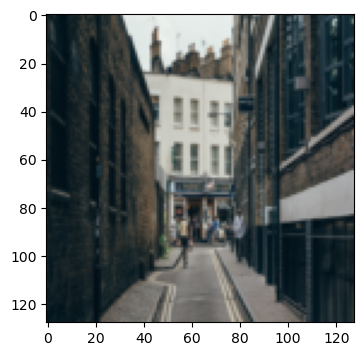

patches: torch.Size([1, 16, 3072])


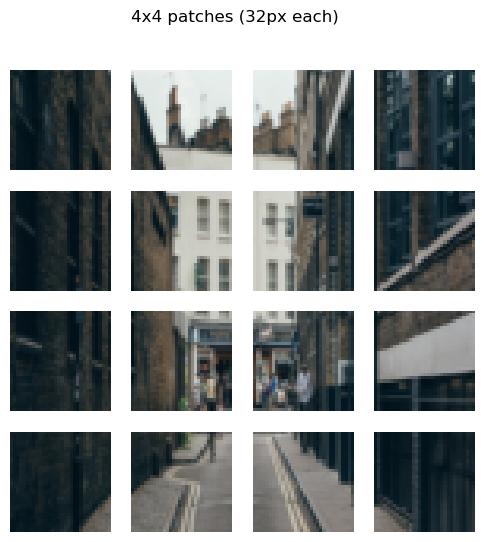

In [ ]:
#Lowkey ignore this lol this is me trying to test to see if the patching is actually working with visuals.
#THIS TOOK WAY TOO FCKING LONG AAAAGH (ye i give up chatgpt go brrr help me make sure my stupid codes working)
img_size = 128
patch_size = 32
embed_dim = 128


# --- Load one example from CLIC ---
ds = tfds.load("clic", split="validation[:1]", as_supervised=False)  # load the CLIC dataset (only 1 sample from validation split)
ex = next(iter(tfds.as_numpy(ds))) # convert TF tensors -> NumPy so it can be accessed, then take the first element
arr = ex["image"]  # take the actual image instead of any other elements (like the metadata lol)

#Just reform it to 128 128 for consistency purposes
to_tensor = transforms.Compose([
    transforms.Resize((128,128)), 
    transforms.ToTensor(),    #turn into a tensor
])
img = to_tensor(Image.fromarray(arr))
x = img.unsqueeze(0)          # add batch -> (1,3,128,128)

# --- Run through PatchEmbed ---
pe = PatchEmbed(img_size=128, patch_size=32, in_chans=3, embed_dim=128)
tokens = pe(x)

print("input:", x.shape)       # (1, 3, 128, 128)
print("tokens:", tokens.shape) # (1, 16, 128)

# ---- Visualization: show original image ----
plt.figure(figsize=(4,4))
plt.imshow(img.permute(1,2,0).numpy())  # (C,H,W) -> (H,W,C)
plt.show()


#Lowkey you guys can ignore this next part i'm just testing to make sure that the image is being patched (like each patch when reverted is 32 x 32 pixels)
# ---- Raw patchify (pixels) using unfold ----
patches = F.unfold(x, kernel_size=32, stride=32)  # (B, C*p*p, N)
patches = patches.transpose(1, 2)                 # (B, N, C*p*p)

B, N, PP = patches.shape
C = x.shape[1]
p = 32
gh = gw = int((N)**0.5)  # grid = 4x4 since 128/32 = 4

print("patches:", patches.shape)  # (1, 16, 3072)

# ---- Visualize patches side by side ----
fig, axs = plt.subplots(gh, gw, figsize=(6,6))
for idx in range(N):
    patch = patches[0, idx].reshape(C, p, p).permute(1,2,0).numpy()
    r, c = divmod(idx, gw)
    axs[r, c].imshow(patch)
    axs[r, c].axis("off")

plt.suptitle(f"{gh}x{gw} patches ({p}px each)")
plt.show()
